## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/se_cells_meta.tsv"
p_thresh = 0.1 
out_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/hypergeom_clone_clust/mincl.10_bothConds.False_p0.1/input_hypergeom.csv"

min_clone_size = 10

input_cond = "Input"
#conds_sep = False

In [2]:
import pandas as pd
import numpy as np
from os.path import join
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t")
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if not "cluster_labels" in cells_meta.columns.values:
    cells_meta["cluster_labels"] = cells_meta["seurat_clusters"]
    
    
sizes = cells_meta.groupby("name").size().sort_values(ascending=False)

cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
name_cond_size = cells_meta.groupby(["name"]).size()
name_cond_size = name_cond_size[name_cond_size>min_clone_size]
clones_filt = name_cond_size.index 

sizes = sizes.loc[clones_filt].sort_values(ascending=False)
clones_filt

groups = cells_meta.groupby(["cluster_labels", "name"]).size().reset_index().rename({0:"count"}, axis=1)
groups

clones = clones_filt#np.unique(groups["name"])
clones

atac_cl = np.unique(groups["cluster_labels"])
atac_cl

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [4]:
#p(k,M,n,N) = (n choose k)((M-n)choose(N-k))/(MchooseN)
#pmf(k, M, n, N) = choose(n, k) * choose(M - n, N - k) / choose(M, N),
                               #for max(0, N - (M-n)) <= k <= min(n, N)
    
# M: Total number of cells
# n: Number of cells in the atac cluster (group population)
# N: Number of cells in clone (the draw)
# x: Number of cells in specific clone and cluster
enrichment_df = pd.DataFrame(index=clones,
                             columns=atac_cl, dtype=np.float128)

M = groups["count"].sum()
for cl in clones:
    for atac in atac_cl:     
        n = groups[groups["seurat_clusters"]==atac]["count"].sum()
        N = groups[groups["name"]==cl]["count"].sum()
        
        x = groups[((groups["name"]==cl)& (groups["seurat_clusters"]==atac))]["count"].sum()
        
        # rv = hypergeom(M, n, N)
        prb = 1 - hypergeom.cdf(x, M, n, N)
        enrichment_df.loc[cl, atac] = prb
        

In [5]:
enrichment_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
name,,,,,,,,,,,,,,,
0_0,0.212312,0.331461,0.712596,0.043644,0.697052,0.463070,0.133641,0.997499,0.910518,0.037747,0.015059,0.950309,0.085124,0.091501,0.033490
0_1,0.279397,0.660724,0.998430,0.000003,0.298221,0.765754,0.552033,0.846660,0.841749,0.314347,0.206720,0.433084,0.290421,0.790479,0.308744
0_10,0.090208,0.012283,0.872461,0.289656,0.008418,0.233818,0.224569,0.246104,0.209556,0.018680,0.113656,0.051298,0.119502,0.405902,0.134484
0_11,0.008919,0.009046,0.863571,0.051297,0.863103,0.070842,0.022358,0.992621,0.628682,0.231992,0.228795,0.654856,0.732292,0.093801,0.867588
0_13,0.722406,0.904207,0.927247,0.000003,0.567484,0.139941,0.659702,0.829068,0.607119,0.225562,0.479905,0.897396,0.181071,0.915806,0.858855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_5,0.267631,0.434493,0.181713,0.677441,0.373747,0.584175,0.567407,0.034286,0.177754,0.060235,0.058695,0.203447,0.595229,0.820148,0.080291
1_6,0.391301,0.710188,0.276706,0.983905,0.003721,0.012666,0.150282,0.004389,0.239227,0.239436,0.826444,0.146379,0.937463,0.979533,0.148100
1_7,0.781089,0.513498,0.009682,0.984859,0.182516,0.403190,0.566826,0.026267,0.001025,0.261389,0.856106,0.227433,0.987872,0.989059,0.190060


In [6]:
reject, pvals_corrected, _, _ = multitest.multipletests(enrichment_df.values.flatten(), alpha=p_thresh, method="fdr_bh")

In [7]:
nrows, ncols = enrichment_df.shape
reject, pvals_corrected, _, _ = multitest.multipletests(enrichment_df.values.flatten(),
                                                        alpha=p_thresh, method="fdr_bh")
pvals_corrected = np.reshape(pvals_corrected, [nrows,ncols])
bh_enrichment_df = enrichment_df.copy()
bh_enrichment_df.loc[:,:] = pvals_corrected
bh_enrichment_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
name,,,,,,,,,,,,,,,
0_0,0.503792,0.594425,0.836253,0.286669,0.827270,0.665198,0.434234,0.999954,0.967039,0.277402,0.201099,0.987275,0.365362,0.365799,0.268152
0_1,0.561019,0.801990,0.999954,0.001660,0.576948,0.872232,0.732699,0.930718,0.926347,0.587388,0.498298,0.645512,0.572534,0.893266,0.585918
0_10,0.365799,0.184786,0.942082,0.572534,0.156823,0.527803,0.516603,0.535528,0.501012,0.215639,0.403558,0.298784,0.410202,0.629763,0.434394
0_11,0.159765,0.159765,0.939704,0.298784,0.939704,0.341076,0.230631,0.999954,0.787566,0.526151,0.523027,0.801990,0.850328,0.370035,0.941535
0_13,0.842422,0.962203,0.977223,0.001660,0.744186,0.439633,0.801990,0.918855,0.773017,0.517799,0.682462,0.956814,0.475328,0.970772,0.937633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_5,0.555031,0.645512,0.475328,0.810652,0.621372,0.755224,0.744186,0.268152,0.472015,0.314658,0.313516,0.498215,0.765893,0.913594,0.361805
1_6,0.624734,0.835291,0.559849,0.999954,0.115091,0.184925,0.441775,0.115091,0.529899,0.529899,0.918737,0.439633,0.978315,0.999954,0.439633
1_7,0.886313,0.702213,0.161752,0.999954,0.475328,0.629763,0.744186,0.250103,0.064150,0.545182,0.936499,0.521002,0.999954,0.999954,0.479529


In [8]:
output_df = pd.DataFrame(index=sizes.index)
output_df["significant clusters"] = ""
output_df["size"] = sizes
#output_df["min_significance"] = None

sig_results = []
sig_order = []
for ind, val in bh_enrichment_df.loc[sizes.index].iterrows():
    passed = val[val<p_thresh].index.values
    if len(passed)>0:
        output_df.loc[ind, "significant clusters"] = ";".join([str(x) for x in passed])
        output_df.loc[ind, "min_significance"] = min(val)
       # sig_results.append((ind, passed))
output_df.loc[:, bh_enrichment_df.columns] = bh_enrichment_df.loc[output_df.index]
output_df = output_df.sort_values("min_significance")

output_df = output_df.loc[~(output_df["min_significance"].isnull())]
output_df

(73, 18)

In [10]:
output_df.to_csv(out_f, sep=",")

In [12]:
output_df=output_df.sort_values("size", ascending=True)
bh_enrichment_df[bh_enrichment_df>p_thresh] = 1
bh_enrichment_df[bh_enrichment_df==0] = min(p_thresh,min(set((bh_enrichment_df.values).flatten())-{0})) # Set to the next min, or p_thresh, whichever is smaller


[Text(0.5, 1.0, '-log10 p-value')]

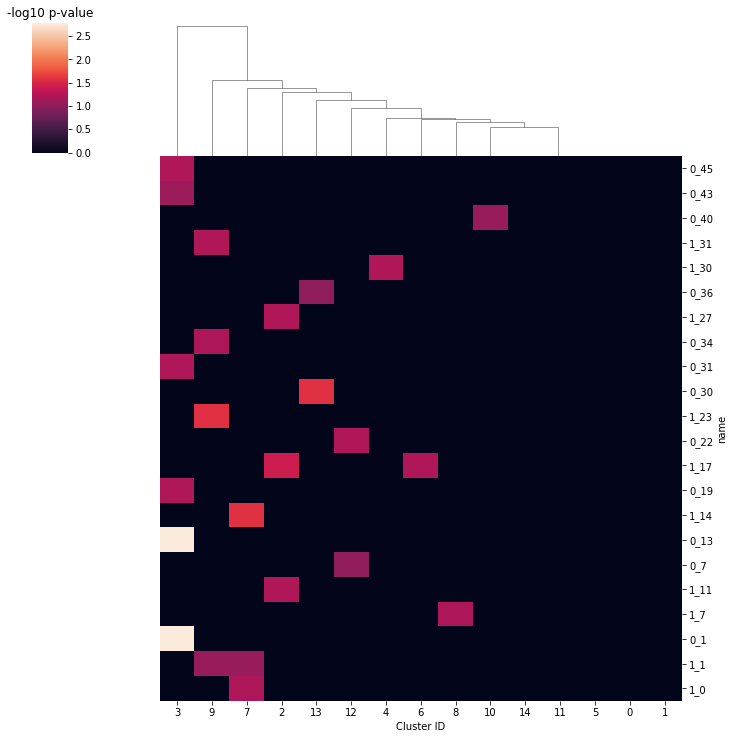

In [13]:

g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
               row_cluster=False)
g.ax_heatmap.set(xlabel="Cluster ID")
g.ax_cbar.set(title="-log10 p-value")

In [14]:
%load_ext autoreload
%autoreload 2

## Add in colors

In [15]:
anno_labels = np.sort(output_df["size"].unique())

anno_pal = sns.cubehelix_palette(len(anno_labels),
                                    light=.9, dark=.2, reverse=True,
                                    rot=.1, start=2.8)
anno_lut = dict(zip(map(str, anno_labels), anno_pal))

anno_colors = pd.Series(anno_lut)
anno_colors

output_df["clone_size"] = output_df["size"].apply(lambda x: anno_colors.loc[str(x)])


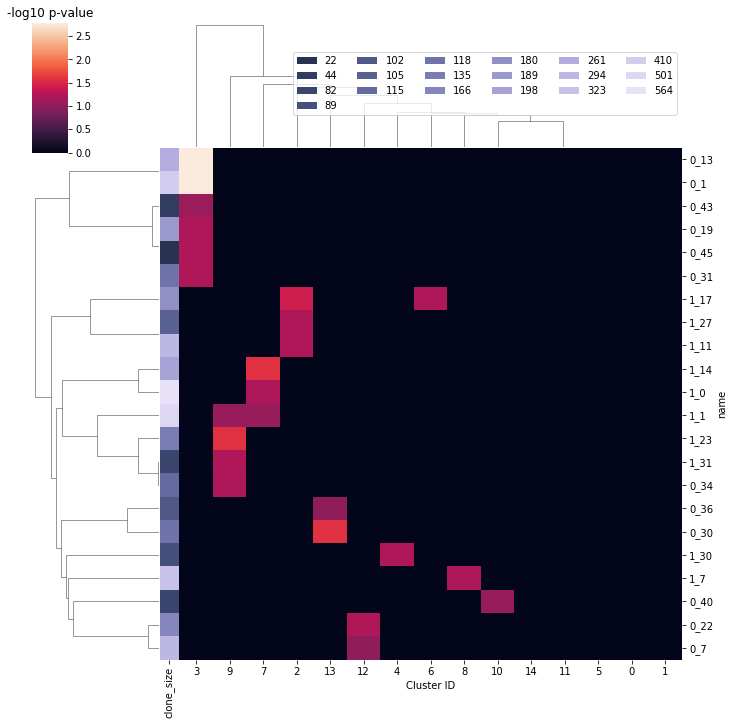

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
                   row_cluster=True, row_colors=output_df[["clone_size"]])
g.ax_heatmap.set(xlabel="Cluster ID")
g.ax_cbar.set(title="-log10 p-value")

for label in anno_labels:
    g.ax_col_dendrogram.bar(0, 0, color=anno_lut[str(label)],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="right", ncol=6)
#g.cax.set_position([.15, .2, .03, .45])
plt.savefig(out_f+".png")

### Without clustering clones

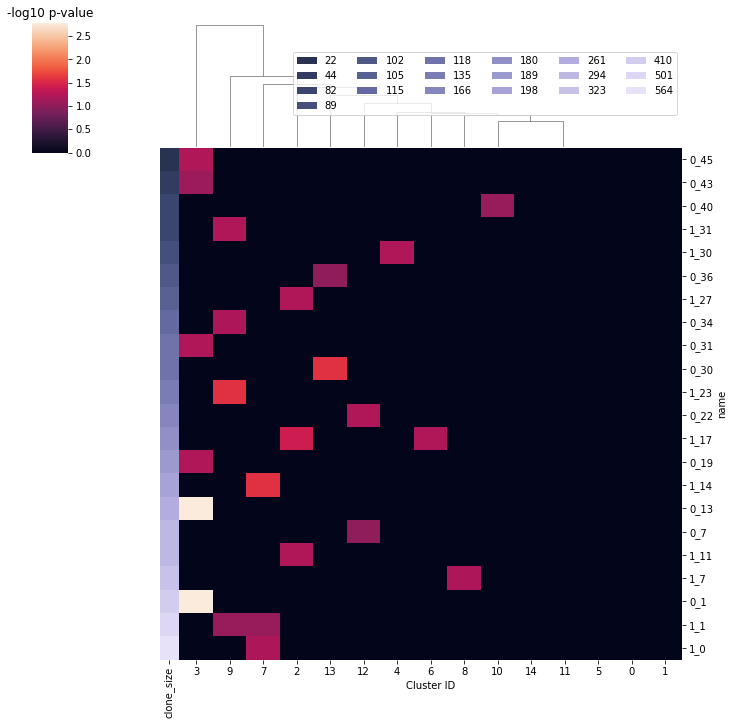

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
                   row_cluster=False, row_colors=output_df[["clone_size"]])
g.ax_heatmap.set(xlabel="Cluster ID")
g.ax_cbar.set(title="-log10 p-value")

for label in anno_labels:
    g.ax_col_dendrogram.bar(0, 0, color=anno_lut[str(label)],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="right", ncol=6)
#g.cax.set_position([.15, .2, .03, .45])
